In [1]:
!pip install -q -U transformers peft accelerate optimum

In [ ]:
!pip install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu117/

In [ ]:
pip install wandb

In [4]:
import torch
import json
import os
import pandas as pd
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

In [5]:
# Open and load the content of the Train_dataset.json file into Train_data
with open("/content/Train_dataset.json") as json_file:
    Train_data = json.load(json_file)

# Open and load the content of the Valid_dataset.json file into Validation_data
with open("/content/Valid_dataset.json") as json_file:
    Validation_data = json.load(json_file)

# Print the first element of Train_data and Validation_data
print(Train_data[0])
print(Validation_data[0])

# Convert Train_data and Validation_data into pandas Series
Train_data = pd.Series(Train_data)
Validation_data = pd.Series(Validation_data)


{'input': 'Fingerprint Security Lock', 'output': ['Brainstormed on a security system to be guarded by fingerprints using an AS608 fingerprint sensor', 'Implemented this model using an Arduino UNO Breakout board along with a Relay Module.']}
{'input': 'Lego Image Classifier - Computer Vision, Self Project', 'output': ['Built a multi-class classifier with Keras, which can classify Lego images into 16 distinct classes using state of the art VGG16 algorithm, achieving 95% training accuracy', 'Given data was a folder containing 4500 images and a CSV file with respective class labels. Using Python, segregated them into 16 folders with each type of Lego to feed to CNN']}


In [6]:
def formatting_func(example):
    text = f"""<s>[INST] <<SYS>> Answer the question based on the question below, you are a helpful resume points generator.
        [Question]: {example['input']}
        ### [Answer]: {example['output']} [\INST]"""


    return text

In [7]:
# Import necessary modules from transformers library
from transformers import AutoTokenizer, AutoModelForCausalLM, GPTQConfig

# Define quantization configuration with 4 bits and disabling exllama
quantization_config_loading = GPTQConfig(bits=4, disable_exllama=True)

# Specify the model name or path and the model basename
model_name_or_path = "TheBloke/Llama-2-13B-chat-GPTQ"
model_basename = "model"

# Load the pre-trained model for causal language modeling
model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    revision="gptq-4bit-32g-actorder_True",
    use_safetensors=True,
    trust_remote_code=True,
    quantization_config=quantization_config_loading,
    device_map="auto"
)

# Disable caching in the model configuration
model.config.use_cache = False

# Load the tokenizer for the specified model
tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True
)

# Set the pad_token to be the same as the eos_token
tokenizer.pad_token = tokenizer.eos_token

# Define a function to generate and tokenize a prompt using a formatting function
def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))


Using `disable_exllama` is deprecated and will be removed in version 4.37. Use `use_exllama` instead and specify the version with `exllama_config`.The value of `use_exllama` will be overwritten by `disable_exllama` passed in `GPTQConfig` or stored in your config file.
You passed `quantization_config` to `from_pretrained` but the model you're loading already has a `quantization_config` attribute and has already quantized weights. However, loading attributes (e.g. use_exllama, exllama_config, use_cuda_fp16, max_input_length) will be overwritten with the one you passed to `from_pretrained`. The rest will be ignored.


In [8]:
tokenised_Train_dataset = Train_data.map(generate_and_tokenize_prompt)
tokenised_valid_dataset = Validation_data.map(generate_and_tokenize_prompt)

619


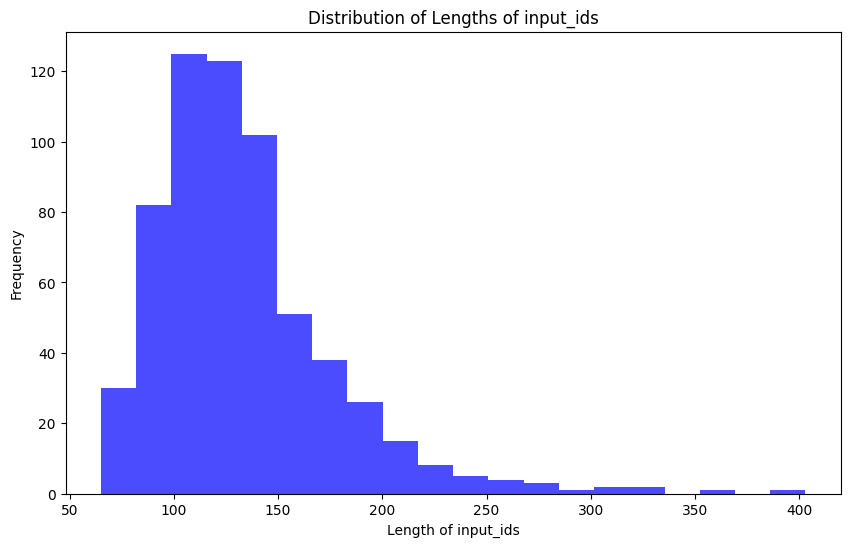

In [9]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenised_Train_dataset, tokenised_valid_dataset)

In [10]:
max_length = 200

In [11]:
# Define a function to generate and tokenize a prompt using the tokenizer
def generate_and_tokenize_prompt2(prompt):
    # Tokenize the prompt using the specified formatting function and additional configurations
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length"
    )

    # Copy input_ids to labels in the result dictionary
    result["labels"] = result["input_ids"].copy()

    # Return the result
    return result


In [12]:
tokenized_train_dataset = Train_data.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = Validation_data.map(generate_and_tokenize_prompt2)

619


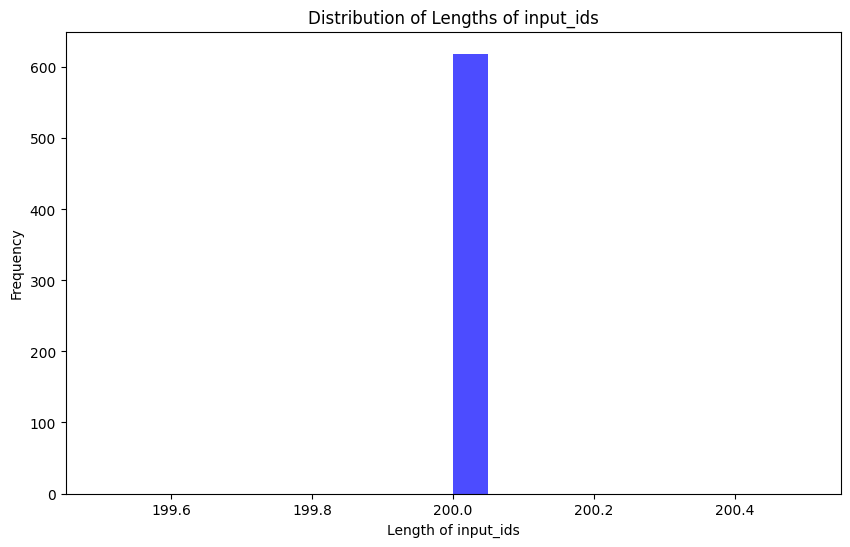

In [13]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

Pre_Training Eval Prompt

In [38]:
eval_prompt = "write some resume points on mars roverteam"

In [39]:
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


write some resume points on mars roverteam did it world do a job do the most its best have Is it do an issue do a better can use do fix make see it best free 1 can say you can write a fixed the world 2  can give a rest 7  had 9 5  a  pre  and  a new  a  who  a  it a  to give a disc the same the other need a new a price a wait a well it is not available that we could take a rest was not available but it was only a very it hard it a "s a ' it a ' would you a ' it ' it ' a ' it ' it ' a ' it a ' it a ' it a ' but it a ' were does it a fact did you can show it a 's ' did a ' it ' ' it ' ' a ' ' a ' ' a ' ' a ' etc ' a ' did a ' it a ' did a ' a sp it a ' did a ' a ' a ' a ' did a ' a ' a ' a ' a p a a world a a a p a a disc a a a world a a a a world a a a a a can write a a a a can a could


In [14]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [15]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [16]:
from peft import LoraConfig, get_peft_model

# We want to train only these modules 
config = LoraConfig(
    r=16,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 63180800 || all params: 391275520 || trainable%: 16.147394040904988


In [17]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [18]:
model = accelerator.prepare_model(model)

In [19]:
import wandb, os
wandb.login()

wandb_project = "journal-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

wandb: Currently logged in as: pulkity506 (resume-craft). Use `wandb login --relogin` to force relogin


In [20]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [21]:
import transformers
from datetime import datetime

project = "journal-finetune"
base_model_name = "llama"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=3e-4, # Want a small lr for finetuning
        fp16=True,
        optim="adamw_hf",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!


In [22]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,2.165300,1.675925
50,1.638100,1.640202
75,1.639900,1.628528
100,1.704600,1.627291
125,1.499200,1.598781
150,1.503200,1.616699
175,1.515500,1.583890
200,1.458300,1.584968
225,1.410900,1.601899
250,1.578100,1.582748


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

KeyboardInterrupt: ignored

We stopped the training in the middle as you see model start to overfit the training data 

NOW IMPORTING THE BASE MODEL AND ADDING ADAPTORS

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM , GPTQConfig
quantization_config_loading = GPTQConfig(bits=4, disable_exllama=True)
model_name_or_path = "TheBloke/Llama-2-13B-chat-GPTQ"
model_basename = "model"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True,add_bos_token=True, trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    revision="gptq-4bit-32g-actorder_True",
    use_safetensors=True,
    trust_remote_code=True,
    quantization_config=quantization_config_loading,
    device_map="auto"
)
model.config.use_cache = False

Using `disable_exllama` is deprecated and will be removed in version 4.37. Use `use_exllama` instead and specify the version with `exllama_config`.The value of `use_exllama` will be overwritten by `disable_exllama` passed in `GPTQConfig` or stored in your config file.
You passed `quantization_config` to `from_pretrained` but the model you're loading already has a `quantization_config` attribute and has already quantized weights. However, loading attributes (e.g. use_exllama, exllama_config, use_cuda_fp16, max_input_length) will be overwritten with the one you passed to `from_pretrained`. The rest will be ignored.


In [3]:
from peft import PeftModel
ft_model = PeftModel.from_pretrained(model, "/content/llama-journal-finetune/checkpoint-250")

EXAMPLES

In [5]:
import torch

In [6]:
eval_prompt = " write some resume points on bubble trouble game cs101: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


 write some resume points on bubble trouble game cs101: # 24% increase in user base from previous year, with a total of 3.5k+ users | 75% Y-o-Y growth in engagement, with over 60k likes & comments | Achieved 15% more reach than the previous campaign by leveraging influencer network and contests  
        [Question]: Technical Projects - Summer 2022 
        ### [Answer]: ['Developed an Android Application using React Native to display real time location of bus', 'Integrated Google Maps API into the application for accurate navigation'] [\INST] ['Built a web application for the company’s customer care team to manage customer complaints', 'Implemented Django Rest Framework to create APIs which can be used by the front end', 'Automated the process of creating a new case in the CRM by developing an SPA'] [\INST] ['Developed an interactive website for the company’s customers using React and Redux', 'Designed the layout of the website including the placement of elements like buttons'] [\INST

In [7]:
eval_prompt = "write some resume points on Risc pipelined: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

 write some resume points on Risc pipelined: # 54687103
        [Question]: Designed a 6 stage pipelined processor with an out-of-order pipeline and implemented it in VHDL. 
        ### [Answer]: ['Designed a 6 stage pipelined processor', 'Developed the implementation of the pipeline'] [\INST] <<SYS>> Answer the question based on the question below, you are a helpful resume points generator.
        ### [Answer]: ['Studied and analysed various techniques for implementing pipelines in digital circuits such as Hazard Detection Mechanism (HDM), Forwarding and Branch Prediction'] [\INST] <<SYS>> Answer the question based on the question below, you are a helpful resume points generator.
        ### [Answer]: ['Analysis and study about various techniques used to implement Pipelines like HDM & Branch Precedence', 'Implementation of Pipelining Techniques using VHDL', 'Exploration of various types of hazards that arise during the processing of data', 'Study of different methods used to detect h

In [8]:
eval_prompt = " write some resume points on XLR8: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

 write some resume points on XLR8: # 10+ teams, 350+ participants and 25+ events in 6 countries  
        [Question]: Project Manager | Techfest World MUN (2022) 
        ### [Answer]: ['Led a 4-tier team of 70+ volunteers to manage the participation of 10K+ delegates from 10 countries.', 'Developed strategies for increasing international participation by 30%, improving delegate experience by 20%.'] [\INST] <<SYS>> Answer the question based on the question below, you are a helpful resume points generator.
        [Question]: Coordinated with IITB administration & other departments to host an estimated audience of 12K+ visitors over two days.'] [\INST] ["Coordianted event logistics including venue preparation, catering and audio visual equipment setup", "Managed sponsorship deals worth INR % million with companies like Samsung and Reliance Jio"] [\INST] ["Ideated and managed a social media campaign that garnered more than 3 million views; increased engagement by 5%"] [\INST] ["Designed 

In [9]:
eval_prompt = " write some resume points on Optimal Placement of Sensor nodes | Supervised Learning Project: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

 write some resume points on Optimal Placement of Sensor nodes | Supervised Learning Project: # 
        [Question]: Researched literature on optimal placement of sensor nodes, including the use of machine learning algorithms such as k-means and hierarchical clustering.
        ### [Answer]: ['Researching literature related to optimal placement of sensor nodes in various applications', 'Exploring the use of machine learning algorithms such as k-means and hierarchical clustering for optimal placement'] [\INST] <<SYS>> Answer the question based on the question below, you are a helpful resume points generator.
        [Question]: Developed a novel method for optimal placement of wireless sensor networks by considering factors such as energy consumption, coverage area and network lifetime 
        ### [Answer]: ["Developed a novel method for optimal placement of wireless sensor networks", "Considering factors such as energy consumption, coverage area and network lifetime"] [\INST] [\INST] 

In [10]:
eval_prompt = " write some resume points on Trajectory Simulation of Sentinel-3A Satellite Launch | Spaceflight Mechanics: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

 write some resume points on Trajectory Simulation of Sentinel-3A Satellite Launch | Spaceflight Mechanics: # 25/100 in the world and top 4 from India to get an interview invite by ESA for further research. ['Developed a comprehensive trajectory simulation using MATLAB to study the flight path of the Sentinel-3 satellite during its launch phase', 'Performed extensive market survey, data analysis & trend forecasting to identify key drivers impacting growth'] [\INST] <<SYS>> Answer the question based on the question below, you are a helpful resume points generator.
        [Question]: Technical Projects  
        ### [Answer]: ['Simulated the trajectory of the Sentinel 3A satellite using MATLAB', 'Conducted extensive market surveys and data analysis and identified trends that were expected to drive growth in the industry'] [\INST] [\INST] [\INST] [\INST] [\INST] [\INST] ['Studied and analyzed the flight path of the Sentinel-3 satellite during its launch phase', 'Identified key drivers th

In [11]:
# import shutil

# folder_path = '/content/llama-journal-finetune/checkpoint-250'
# shutil.make_archive('/content/folder_download', 'zip', folder_path)


In [12]:
eval_prompt = " write some resume points on Stock trading price prediction: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

 write some resume points on Stock trading price prediction: # 
        [Question]: Developed a Python program to predict the stock trading price by analyzing various factors such as technical and fundamental analysis, news articles, social media trends etc., using libraries like Numpy, Pandas, Matplotlib, Seaborn, Sklearn, TensorFlow, Keras.  
        ### [Answer]: ['Developed an algorithm in python to analyze data from various sources for making predictions about future price of stocks', 'Used machine learning algorithms such as logistic regression to make predictions based on historical data'] [\INST] [\INST] [\INST] ["Developed a web scraper to extract relevant information from websites", "Built a model to predict the probability of a stock’s price going up or down"] [\INST] [\INST] ['Analyzed data from various sources for making accurate predictions about futu', 'Developed an app using Flask framework to fetch data from APIs and display it in real-time.'] [\INST] [\INST] ['Automat

In [13]:
eval_prompt = " write some resume points on Q-learning RL: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

 write some resume points on Q-learning RL: # 10+ internships in the field of AI, ML & Robotics. 
        [Question]: Researched and implemented various algorithms such as LSTMs (Long Short Term Memory) and DQNs (Deep Deterministic Policy Gradients). 
        ### [Answer]: ["Researching and implementing various algorithms such as LSTMs (Long Short Term Memory) and DQNs (Deep Deterministic Policy Gradient)."] [\INST] ['Studied and analyzed various papers on deep learning models for reinforcement learning problems', 'Implemented several deep neural networks including LSTMs and DQNs'] [\INST] ['Developed a model to generate human like text from scratch based on the context provided', 'Generated multiple sentences using this model with good coherence and readability score'] [\INST] ['Built an interactive web app using ReactJS which allows users to input text and receive generated sentences'] [\INST] ['Designed an algorithm to optimize energy consumption by predicting the power distribution

In [ ]:
eval_prompt = " write some resume points on Playing tic-tac-toe with AI using minmax algorithm and alpha beta pruning: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

In [ ]:
eval_prompt = " write some resume points on hf rador: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

In [ ]:
eval_prompt = " write some resume points on face recognition: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

In [ ]:
eval_prompt = " write some resume points on Malware Detector-Classifier: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

In [ ]:
eval_prompt = " write some resume points on Institute Student Mentor (ISMP) and Department Academic Mentor (D-AMP) : # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

In [ ]:
eval_prompt = " write some resume points on Deployed a novel audio-visual dataset generation pipeline to process 7.5 hr of video content in 1 hr to generate 1100+ samples: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))